# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


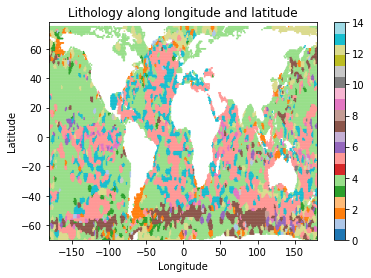

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

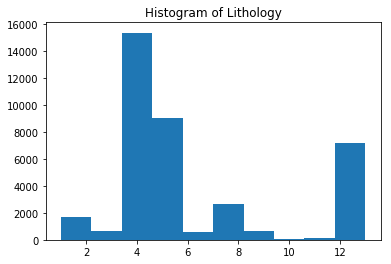

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using Theano backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
dropout_ratio = 0.2
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

Train on 20292 samples, validate on 5074 samples
Epoch 1/200
20292/20292 [==============================] - 2s 92us/step - loss: 1.4951 - acc: 0.4574 - val_loss: 1.5796 - val_acc: 0.4809
Epoch 2/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.3993 - acc: 0.5034 - val_loss: 1.6051 - val_acc: 0.4896
Epoch 3/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.3685 - acc: 0.5128 - val_loss: 1.5746 - val_acc: 0.4943
Epoch 4/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.3480 - acc: 0.5189 - val_loss: 1.6235 - val_acc: 0.4880
Epoch 5/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.3308 - acc: 0.5238 - val_loss: 1.5804 - val_acc: 0.5116
Epoch 6/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.3210 - acc: 0.5268 - val_loss: 1.5975 - val_acc: 0.5020
Epoch 7/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.3044 - acc: 0.5306 - val_loss: 1.6149 - v

20292/20292 [==============================] - 2s 91us/step - loss: 1.1665 - acc: 0.5663 - val_loss: 1.7681 - val_acc: 0.5101
Epoch 60/200
20292/20292 [==============================] - 2s 92us/step - loss: 1.1658 - acc: 0.5668 - val_loss: 1.8105 - val_acc: 0.4933
Epoch 61/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1637 - acc: 0.5697 - val_loss: 1.7754 - val_acc: 0.5045
Epoch 62/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1594 - acc: 0.5691 - val_loss: 1.8390 - val_acc: 0.4929
Epoch 63/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1610 - acc: 0.5670 - val_loss: 1.7901 - val_acc: 0.4988
Epoch 64/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1657 - acc: 0.5663 - val_loss: 1.8012 - val_acc: 0.4953
Epoch 65/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1633 - acc: 0.5653 - val_loss: 1.7771 - val_acc: 0.4949
Epoch 66/200
20292/20292 [==============

Epoch 118/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1344 - acc: 0.5847 - val_loss: 1.8425 - val_acc: 0.4927
Epoch 119/200
20292/20292 [==============================] - 2s 91us/step - loss: 1.1270 - acc: 0.5822 - val_loss: 1.8249 - val_acc: 0.4935
Epoch 120/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1292 - acc: 0.5812 - val_loss: 1.8661 - val_acc: 0.4896
Epoch 121/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1327 - acc: 0.5814 - val_loss: 1.8476 - val_acc: 0.5035
Epoch 122/200
20292/20292 [==============================] - 2s 91us/step - loss: 1.1328 - acc: 0.5838 - val_loss: 1.8630 - val_acc: 0.4919
Epoch 123/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1297 - acc: 0.5869 - val_loss: 1.8801 - val_acc: 0.5026
Epoch 124/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1299 - acc: 0.5831 - val_loss: 1.8465 - val_acc: 0.4988
Epoch 125/200
20292/

20292/20292 [==============================] - 2s 91us/step - loss: 1.1208 - acc: 0.5830 - val_loss: 1.8228 - val_acc: 0.4988
Epoch 177/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1185 - acc: 0.5855 - val_loss: 1.9020 - val_acc: 0.4941
Epoch 178/200
20292/20292 [==============================] - 2s 91us/step - loss: 1.1147 - acc: 0.5849 - val_loss: 1.8504 - val_acc: 0.5012
Epoch 179/200
20292/20292 [==============================] - 2s 91us/step - loss: 1.1137 - acc: 0.5879 - val_loss: 1.9347 - val_acc: 0.4886
Epoch 180/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1206 - acc: 0.5871 - val_loss: 1.9068 - val_acc: 0.4821
Epoch 181/200
20292/20292 [==============================] - 2s 90us/step - loss: 1.1137 - acc: 0.5866 - val_loss: 1.8841 - val_acc: 0.5034
Epoch 182/200
20292/20292 [==============================] - 2s 91us/step - loss: 1.1155 - acc: 0.5877 - val_loss: 1.8573 - val_acc: 0.4984
Epoch 183/200
20292/20292 [=======

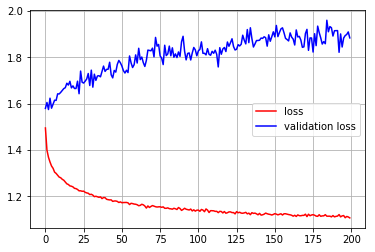

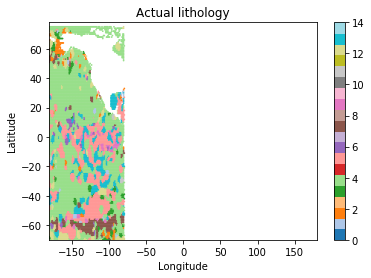

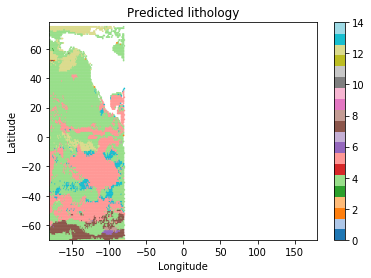

Train on 20292 samples, validate on 5074 samples
Epoch 1/200
20292/20292 [==============================] - 2s 93us/step - loss: 1.3236 - acc: 0.5553 - val_loss: 1.7234 - val_acc: 0.4933
Epoch 2/200
20292/20292 [==============================] - 2s 93us/step - loss: 1.2362 - acc: 0.5759 - val_loss: 1.7307 - val_acc: 0.5051
Epoch 3/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.2089 - acc: 0.5844 - val_loss: 1.7251 - val_acc: 0.4994
Epoch 4/200
20292/20292 [==============================] - 2s 92us/step - loss: 1.1995 - acc: 0.5855 - val_loss: 1.7447 - val_acc: 0.5101
Epoch 5/200
20292/20292 [==============================] - 2s 96us/step - loss: 1.1810 - acc: 0.5924 - val_loss: 1.7881 - val_acc: 0.5022
Epoch 6/200
20292/20292 [==============================] - 2s 92us/step - loss: 1.1805 - acc: 0.5910 - val_loss: 1.8004 - val_acc: 0.5032
Epoch 7/200
20292/20292 [==============================] - 2s 93us/step - loss: 1.1719 - acc: 0.5912 - val_loss: 1.7517 - v

20292/20292 [==============================] - 2s 93us/step - loss: 1.0764 - acc: 0.6190 - val_loss: 1.9682 - val_acc: 0.4953
Epoch 60/200
20292/20292 [==============================] - 2s 93us/step - loss: 1.0753 - acc: 0.6179 - val_loss: 1.9615 - val_acc: 0.4933
Epoch 61/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0713 - acc: 0.6207 - val_loss: 2.0039 - val_acc: 0.4892
Epoch 62/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0749 - acc: 0.6205 - val_loss: 1.9007 - val_acc: 0.4915
Epoch 63/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0754 - acc: 0.6153 - val_loss: 1.9013 - val_acc: 0.4974
Epoch 64/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0717 - acc: 0.6214 - val_loss: 1.9739 - val_acc: 0.4937
Epoch 65/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0710 - acc: 0.6201 - val_loss: 2.0422 - val_acc: 0.4890
Epoch 66/200
20292/20292 [==============

Epoch 118/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0567 - acc: 0.6254 - val_loss: 1.9378 - val_acc: 0.5010
Epoch 119/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0563 - acc: 0.6252 - val_loss: 1.9761 - val_acc: 0.4992
Epoch 120/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0530 - acc: 0.6272 - val_loss: 1.9817 - val_acc: 0.4901
Epoch 121/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0634 - acc: 0.6259 - val_loss: 1.9296 - val_acc: 0.5016
Epoch 122/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0542 - acc: 0.6269 - val_loss: 2.0093 - val_acc: 0.4925
Epoch 123/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0567 - acc: 0.6236 - val_loss: 1.9545 - val_acc: 0.5028
Epoch 124/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0513 - acc: 0.6262 - val_loss: 1.9686 - val_acc: 0.4961
Epoch 125/200
20292/

20292/20292 [==============================] - 2s 95us/step - loss: 1.0536 - acc: 0.6264 - val_loss: 1.9818 - val_acc: 0.4795
Epoch 177/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0475 - acc: 0.6338 - val_loss: 1.9594 - val_acc: 0.5016
Epoch 178/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0432 - acc: 0.6301 - val_loss: 1.9124 - val_acc: 0.4955
Epoch 179/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0586 - acc: 0.6274 - val_loss: 1.9846 - val_acc: 0.4961
Epoch 180/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0512 - acc: 0.6290 - val_loss: 1.9664 - val_acc: 0.4947
Epoch 181/200
20292/20292 [==============================] - 2s 95us/step - loss: 1.0492 - acc: 0.6303 - val_loss: 1.9863 - val_acc: 0.4860
Epoch 182/200
20292/20292 [==============================] - 2s 94us/step - loss: 1.0419 - acc: 0.6285 - val_loss: 1.9918 - val_acc: 0.4921
Epoch 183/200
20292/20292 [=======

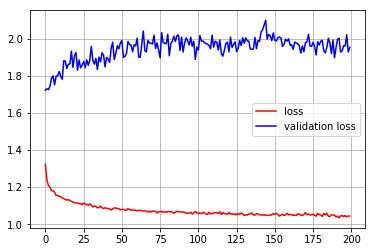

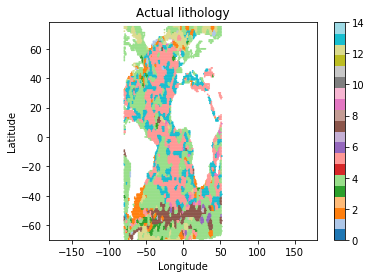

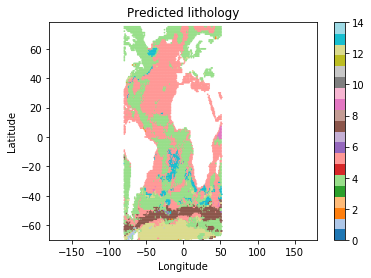

Train on 20292 samples, validate on 5074 samples
Epoch 1/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.1885 - acc: 0.5773 - val_loss: 1.7728 - val_acc: 0.4446
Epoch 2/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.1339 - acc: 0.5947 - val_loss: 1.7980 - val_acc: 0.4139
Epoch 3/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.1155 - acc: 0.6014 - val_loss: 1.7716 - val_acc: 0.4127
Epoch 4/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.1065 - acc: 0.6001 - val_loss: 1.7562 - val_acc: 0.4261
Epoch 5/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.0909 - acc: 0.6068 - val_loss: 1.7928 - val_acc: 0.4227
Epoch 6/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.0875 - acc: 0.6096 - val_loss: 1.8394 - val_acc: 0.4089
Epoch 7/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.0848 - acc: 0.6107 - val_loss: 1.7849 - v

20292/20292 [==============================] - 2s 97us/step - loss: 1.0220 - acc: 0.6342 - val_loss: 1.9293 - val_acc: 0.4123
Epoch 60/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.0045 - acc: 0.6374 - val_loss: 1.9272 - val_acc: 0.4275
Epoch 61/200
20292/20292 [==============================] - 2s 96us/step - loss: 1.0149 - acc: 0.6312 - val_loss: 1.9848 - val_acc: 0.4111
Epoch 62/200
20292/20292 [==============================] - 2s 96us/step - loss: 1.0128 - acc: 0.6351 - val_loss: 1.9391 - val_acc: 0.4338
Epoch 63/200
20292/20292 [==============================] - 2s 97us/step - loss: 1.0065 - acc: 0.6380 - val_loss: 1.9202 - val_acc: 0.4316
Epoch 64/200
20292/20292 [==============================] - 2s 96us/step - loss: 1.0096 - acc: 0.6341 - val_loss: 1.8640 - val_acc: 0.4103
Epoch 65/200
20292/20292 [==============================] - 2s 96us/step - loss: 1.0101 - acc: 0.6347 - val_loss: 1.8983 - val_acc: 0.4296
Epoch 66/200
20292/20292 [==============

Epoch 118/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9914 - acc: 0.6422 - val_loss: 1.9568 - val_acc: 0.4101
Epoch 119/200
20292/20292 [==============================] - 2s 95us/step - loss: 0.9927 - acc: 0.6385 - val_loss: 1.9021 - val_acc: 0.4212
Epoch 120/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9952 - acc: 0.6396 - val_loss: 1.9396 - val_acc: 0.4222
Epoch 121/200
20292/20292 [==============================] - 2s 95us/step - loss: 0.9922 - acc: 0.6403 - val_loss: 1.9124 - val_acc: 0.4320
Epoch 122/200
20292/20292 [==============================] - 2s 95us/step - loss: 0.9909 - acc: 0.6451 - val_loss: 1.9428 - val_acc: 0.4028
Epoch 123/200
20292/20292 [==============================] - 2s 95us/step - loss: 0.9884 - acc: 0.6444 - val_loss: 1.9364 - val_acc: 0.4038
Epoch 124/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9948 - acc: 0.6410 - val_loss: 1.9754 - val_acc: 0.3908
Epoch 125/200
20292/

20292/20292 [==============================] - 2s 96us/step - loss: 0.9893 - acc: 0.6461 - val_loss: 1.9679 - val_acc: 0.4105
Epoch 177/200
20292/20292 [==============================] - 2s 97us/step - loss: 0.9859 - acc: 0.6442 - val_loss: 1.9228 - val_acc: 0.4265
Epoch 178/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9894 - acc: 0.6406 - val_loss: 1.9091 - val_acc: 0.4239
Epoch 179/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9909 - acc: 0.6442 - val_loss: 1.9534 - val_acc: 0.4369
Epoch 180/200
20292/20292 [==============================] - 2s 97us/step - loss: 0.9853 - acc: 0.6463 - val_loss: 1.9752 - val_acc: 0.4121
Epoch 181/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9877 - acc: 0.6432 - val_loss: 1.9394 - val_acc: 0.4322
Epoch 182/200
20292/20292 [==============================] - 2s 96us/step - loss: 0.9784 - acc: 0.6444 - val_loss: 1.9651 - val_acc: 0.4099
Epoch 183/200
20292/20292 [=======

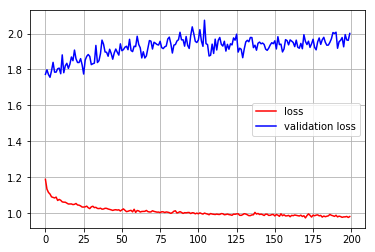

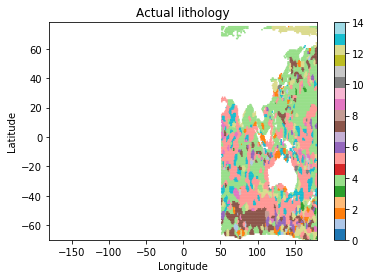

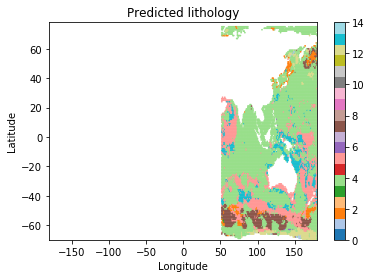

In [7]:
# parameters for training
epochs = 200
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=3, random_state=seed)
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

### Validate

Accuracy = 0.4366211989802623


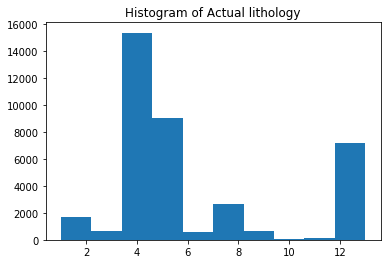

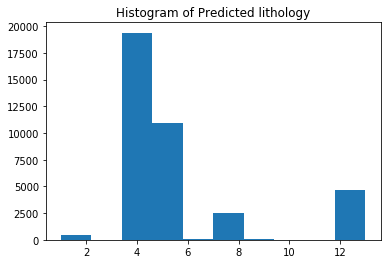

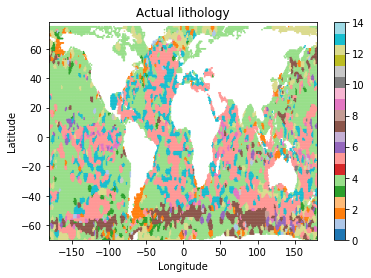

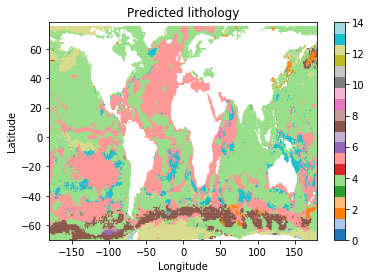

In [8]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

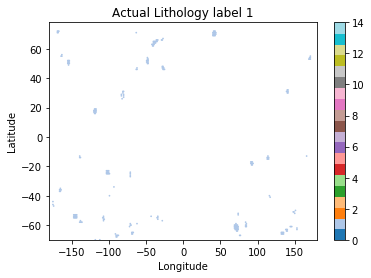

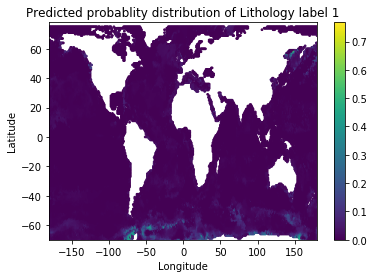

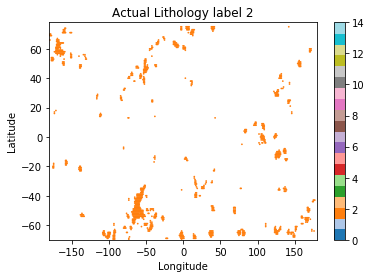

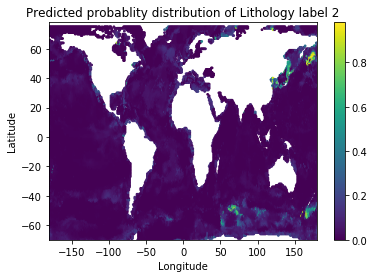

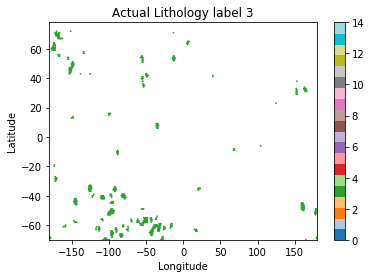

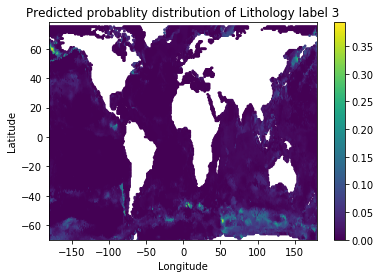

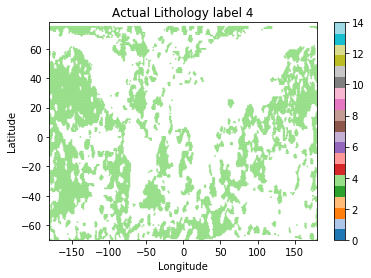

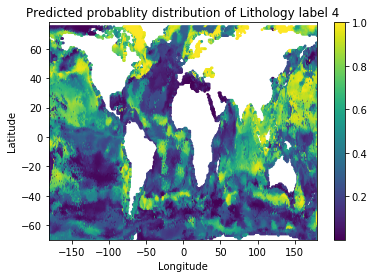

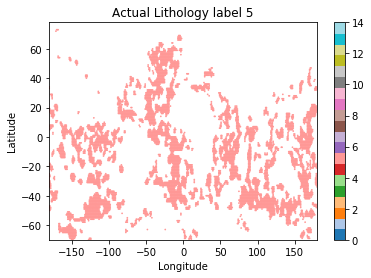

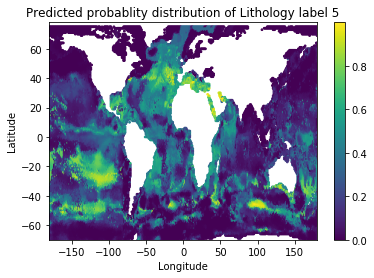

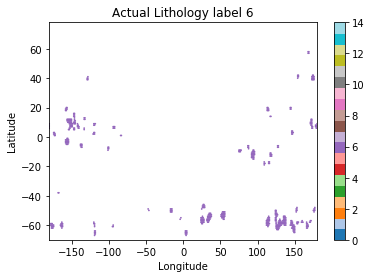

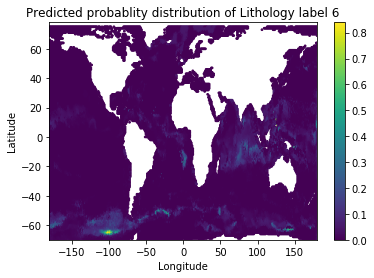

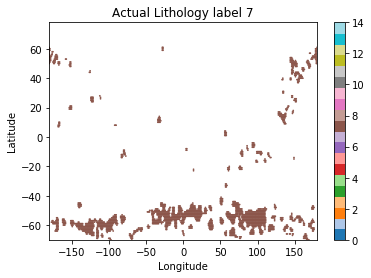

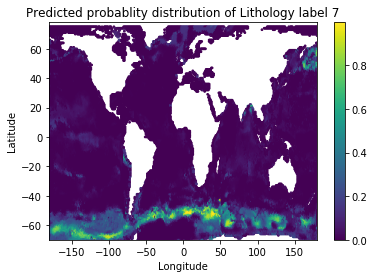

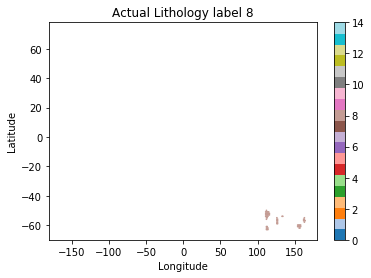

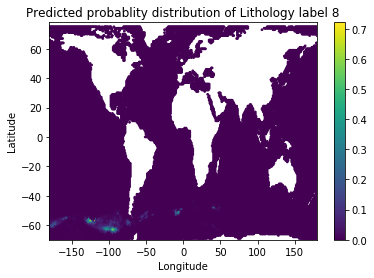

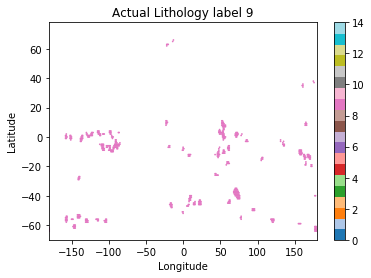

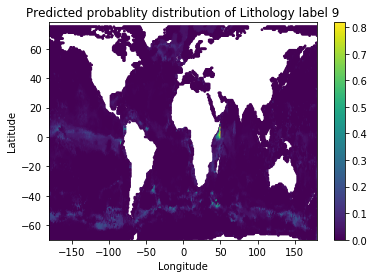

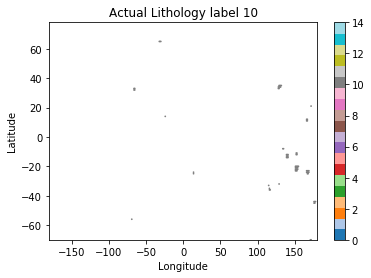

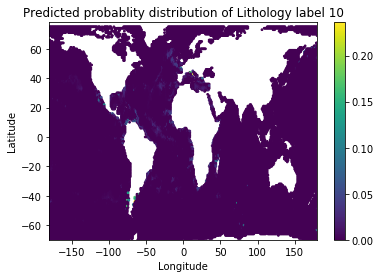

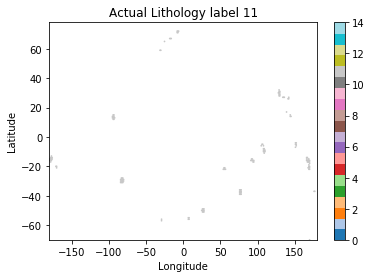

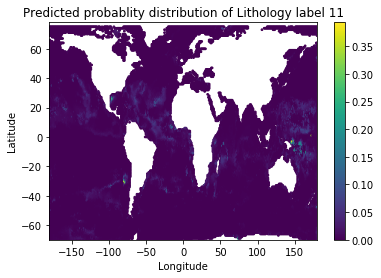

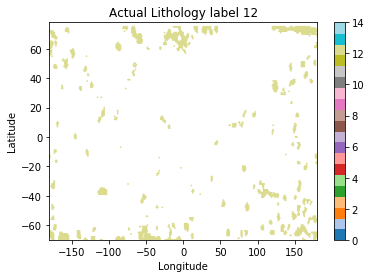

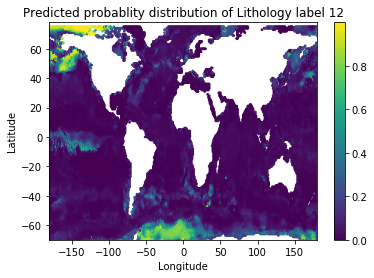

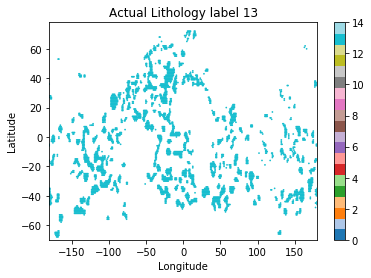

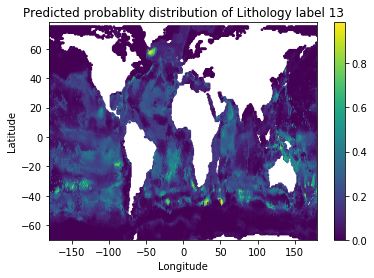

In [9]:
def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)